Gliezel Ann Pajarilla
CMSC 197 - Machine Learning

In [ ]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##### For preprocessing #####
import os
import re
import email
import codecs
##### For performance evaluation #####
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score

###  (1) Initialize the main dataframe. The columns that are included are folder where the email is located, the email's filename, email message, and classification if ham or spam. Note: 0 if ham and 1 if spam.


In [ ]:
#### uploaded the files in the google drive and located the path

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

data_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/data/'
labels_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/labels.txt'
stop_data_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/stop_words.txt'


Mounted at /content/drive


In [ ]:
#### verified the content of the data directory 0 - 127

if os.path.exists(data_path):
    folders = os.listdir(data_path)
    sorted_folders = sorted(folders, key=lambda x: int(x))
    print("Files in the data directory:")
    for folder in sorted_folders:
        print(folder)
else:
    print(f"Directory {data_path} not found.")

Files in the data directory:
000
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


In [ ]:
#### checked the content of the stop words

stop_df = pd.read_csv(stop_data_path, sep= ' ', header = None)
stop_words = set(stop_df[0].tolist())
stop_df.head(10)
stop_df.head(-10)

,0
0,a
1,able
2,about
3,above
4,abst
...,...
656,x
657,y
658,yes
659,yet


###  (2) Turning the spam and ham into a numerical data


In [ ]:
#### initializes the email dataframe

emails_df = pd.DataFrame(columns=['folder', 'file', 'message', 'classification'])

In [ ]:
#### inititialize label dataframe
#### vectorized by turning ham = 0 and spam = 1

labels_df = pd.read_csv(labels_path, sep=' ', header=None, names=['classification', 'folder_file'])
labels_df['classification'] = labels_df['classification'].apply(lambda x: 0 if x == 'ham' else 1)
labels_df['folder'] = labels_df['folder_file'].apply(lambda x: x.replace("../data/", ""))

In [ ]:
labels_df.head()

,classification,folder_file,folder
0,0,../data/000/000,000/000
1,1,../data/000/001,000/001
2,1,../data/000/002,000/002
3,0,../data/000/003,000/003
4,1,../data/000/004,000/004


In [ ]:
emails_df1 = labels_df[['classification', 'folder']]
emails_df1.head()

,classification,folder
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004


In [ ]:
##### Inspecting the data with tot. no of ham and spam

emails_df1.groupby('classification').describe()

folder                     
                count unique      top freq
classification                            
0               12910  12910  000/000    1
1               24912  24912  000/001    1

<ipython-input-13-180ebca1b609>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='classification', data=emails_df1, palette= 'pastel')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


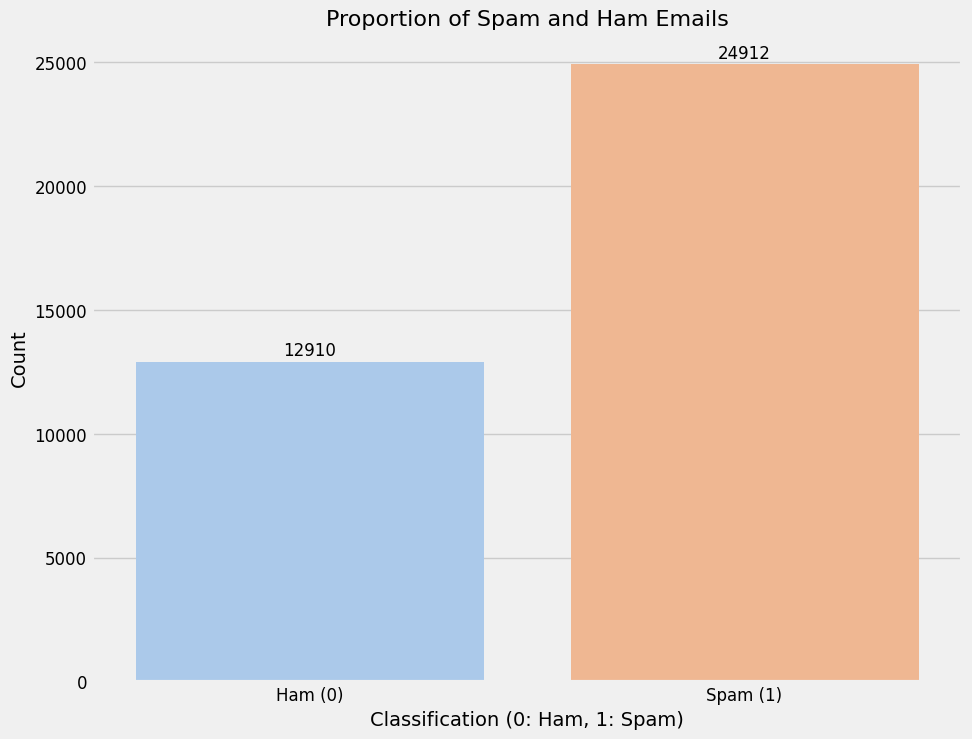

Proportions of Classes:
classification
0    0.341336
1    0.658664
Name: count, dtype: float64


In [ ]:
#### plot visualizations for the no. of ham and spam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
sns.countplot(x='classification', data=emails_df1, palette= 'pastel')
plt.xlabel('Classification (0: Ham, 1: Spam)', fontsize=14)
plt.ylabel('Count', fontsize=14)

## calculating the counts
counts = emails_df1['classification'].value_counts().sort_index()

for index in counts.index:
    plt.text(index, counts[index] + 100, str(counts[index]), ha='center', va='bottom', fontsize=12)

## plot visualizations
plt.title('Proportion of Spam and Ham Emails', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Ham (0)', 'Spam (1)'], fontsize=12)
plt.yticks(fontsize=12)
plt.show()
proportions = counts / counts.sum()
print("Proportions of Classes:")
print(proportions)


### (3) Data Cleaning and Checking for the Missing Values


In [ ]:
#### fuction for removing all unnecessary information
def messages_cleaning(message):
    punctuations = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
    numbers = "0123456789"
    html_tags = re.compile('<.*?>')
    esc_chars = re.compile(r'\\[a-z][a-z]?[0-9]+')
    message = message.lower()
    message = re.sub(html_tags, '', message)
    message = message.translate(str.maketrans('', '', punctuations))
    message = message.translate(str.maketrans('', '', numbers))

    message = re.sub(esc_chars, '', message)
    message = re.sub(r'http\S+|www.\S+', '', message)

    words = message.split()
    words = [word for word in words if word not in stop_words]
    message = " ".join(words)
    return message

In [ ]:
#### extracting original messages from the parsed email
def get_messages(parsed_email):
    message = ""
    if parsed_email.is_multipart():
        for part in parsed_email.walk():
            if part.get_content_type() == "text/plain":
                message = part.get_payload(decode=True).decode(part.get_content_charset() or 'utf-8')
                break
    else:
        message = parsed_email.get_payload(decode=True).decode(parsed_email.get_content_charset() or 'utf-8')
    return message.strip()

In [ ]:
import chardet

def get_email_charset(email_path):
    """Detect the character encoding of the email content."""
    detector = chardet.UniversalDetector()
    with open(email_path, 'rb') as e_mail:
        for line in e_mail:
            detector.feed(line)
            if detector.done:  # Check if the detection is complete
                break
    detector.close()
    return detector.result['encoding']


In [ ]:
#### before going iterating through the files, check a test file if it is being preprocessed accordingly
test_folder = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/data/000'
test_file = "290"
test_path = os.path.join(test_folder, f"{test_file}")
charset = get_email_charset(test_path)

try:
    with open(test_path, 'r', encoding=charset) as e_mail:
        read_email = e_mail.read()
        parsed_email = email.message_from_string(read_email)

        ## extracting original message
        message = get_messages(parsed_email)
        print(f"Original message: {message}")

        ## processing the email message using the cleaning function
        processed_message = messages_cleaning(message)  # Correct function call
        print(f"Processed message: {processed_message}")

except Exception as e:
    print(f"Error occurred: {e}")


Original message: <html>
<head>
<meta http-equiv="Content-Type" content="text/html; charset=euc-kr">
<title></title>
<style type="text/css">
<!--
body {
	margin-left: 0px;
	margin-top: 0px;
	margin-right: 0px;
	margin-bottom: 0px;
}
-->
</style></head>

<body>
<table width="650" border="0" cellspacing="0" cellpadding="0">
<tr>
<td colspan="3"><img src="http://my.netian.com/~dhrwk1/spam3/1.jpg" width="650" height="243"></td>
</tr>
<tr>
<td colspan="3"><img src="http://my.netian.com/~dhrwk1/spam3/2.jpg" width="650" height="187"></td>
</tr>
<tr>
<td width="260"><img src="http://my.netian.com/~dhrwk1/spam3/3.jpg" width="260" height="66"></td>
<td width="144"><a href="http://%65%68%61%70%70%79%6c%6f%61%6e.%63%6f%6d/apply/apply_company01_.loan?mCode444e048aaf542="><img src="http://my.netian.com/~dhrwk1/spam3/button_1.gif" width="144" height="66" border="0"></a></td>
<td width="246"><img src="http://my.netian.com/~dhrwk1/spam3/5.jpg" width="246" height="66"></td>
</tr>
<tr>
<td colspan="3"><i

In [ ]:
folders = os.listdir(data_path)
folders.sort(key=lambda x: int(x))
for folder in folders:
    files = os.listdir(os.path.join(data_path, folder))
    files.sort()
    for file in files:
        try:
            with open(os.path.join(data_path, folder, file), "r", encoding="ISO-8859-1") as e_mail:
                read_email = e_mail.read()
                parsed_email = email.message_from_string(read_email)
                message = get_messages(parsed_email)
                message = messages_cleaning(message)

                ## obtaining category based on df
                category_label = emails_df1[emails_df1["folder"] == f"{folder}/{file}"]["classification"].values[0]

                ## emails_df = pd.DataFrame(columns=['folder', 'file', 'message', 'classification'])

                ## concatenate the data to emails_df
                emails_df = pd.concat([emails_df, pd.DataFrame([[folder, file, message, category_label]], columns=["folder", "file", "message", "classification"])], ignore_index=True)

        except Exception:
            continue

emails_df.head()

,folder,file,message,classification
0,000,000,mailing list queried weeks ago running set arc...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgari...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,chauncey conferred luscious continued tonsillitis,1


In [ ]:
emails_df.head(-20)

,folder,file,message,classification
0,000,000,mailing list queried weeks ago running set arc...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgari...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
35274,125,294,ra side forest streams springs road mirkwood d...,1
35275,125,295,,1
35276,125,297,spruce education touching book will real piece...,1
35277,125,298,ra whistling voices released grasses hissed ta...,1


In [ ]:
#### preprocessed_emails.csv are exported inside a folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

preprocessed_folder = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/preprocessed_data'
if not os.path.exists(preprocessed_folder):
    os.makedirs(preprocessed_folder)



## save to csv
emails_df.to_csv(os.path.join(preprocessed_folder, 'preprocessed_emails.csv'), index=False, escapechar='\\')

print(f"Preprocessed emails path: {preprocessed_folder}/preprocessed_emails.csv")


Mounted at /content/drive
Preprocessed emails path: /content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/preprocessed_data/preprocessed_emails.csv
